Here I am trying to design a data loader for the head-up/head-down classifier.

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

I'll start with the data-loader for labeled crops plus their pixel coordinates. The filenames, HUHD scores, and pixel coordinates for all annotated images are stored in blair_head_annotations.csv.

In [87]:
class HUHDLabeledDataset(Dataset):
    #def __init__(self, csv_file, root_dir):
    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.LabeledCrops = pd.read_csv(csv_file)
        #self.root_dir = root_dir
    
    def __len__(self):
        return len(self.LabeledCrops)
    
    def __getitem__(self, idx):
        img_name = self.LabeledCrops.iloc[idx,0]
        obs = img_name.split('/')[7]
        track = img_name.split('/')[9]
        frame = img_name.split('/')[11].split('_')[2].split('.')[0]
        image = io.imread(img_name)
        label = self.LabeledCrops.iloc[idx,1]
        coords = self.LabeledCrops.iloc[idx,2:4]
        coords = np.array([coords])
        coords = coords.astype('float')
        sample = {'image': image, 'label': label, 'pix_coords_xy': coords, 'observation': obs, 'track': track, 'frame': frame}
        
        return sample
        

In [89]:
HUHD_data = HUHDLabeledDataset('/Volumes/kenya_drones/vigilance/blair_head_annotations.csv')

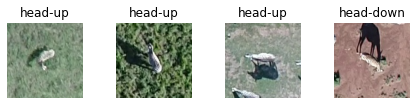

In [96]:
fig = plt.figure()

for i in range(len(HUHD_data)):
    sample = HUHD_data[i]
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    #ax.set_title('Sample #{}'.format(i))
    ax.set_title(sample['label'])
    ax.axis('off')
    plt.imshow(sample['image'])
    
    if i == 3:
        plt.show()
        break